In [1]:
import logging
import time
from datetime import timedelta
from io import BytesIO
from multiprocessing import Pool, cpu_count
from pathlib import Path

import boto3
import contextily as ctx
import datashader as ds
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rio
import s2sphere
import xarray as xr
from botocore.config import Config
from owslib.wfs import WebFeatureService
from rasterstats import zonal_stats
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.stats import genextreme
from shapely.ops import unary_union

In [2]:
# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

project_root = Path.cwd().parent

In [3]:
# Color constants for consistent visualization
COLORS = {
    "water": "#2E86C1",  # Blue for water courses
    "buildings": "#E67E22",  # Orange for buildings
    "flood": "#3498DB",  # Light blue for flood areas
    "population": "#E74C3C",  # Red for population density
    "exceedance": "#2E86C1",  # Blue for exceedance curve
    "exceedance_fit": "#E74C3C",  # Red for fitted curve
    "boundary": "#2C3E50",  # Dark blue-gray for boundaries
}

In [4]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Get the data
    response = wfs.getfeature(typename=layer_name, srsname=srs)

    # Read the response into a GeoDataFrame
    return gpd.read_file(BytesIO(response.read()))

In [50]:
# Load Nono boundary data and project to Web Mercator once
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

# Load water courses data and project directly to Web Mercator
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.overlay(cursos_agua_3857, nono_3857, how='intersection')

cuerpos_de_agua = load_wfs_layer("idecor:embalses")
cuerpos_de_agua_3857 = cuerpos_de_agua.to_crs(epsg=3857)

nono_buffered = nono_3857.copy()
nono_buffered['geometry'] = nono_buffered.geometry.buffer(nono_buffered.geometry.length * 0.03)
cuerpos_de_agua_nono_3857 = gpd.clip(cuerpos_de_agua_3857, nono_buffered)

In [6]:
def scale_line_width(orden):
    return 3 - (orden - 2) * (2.5 / 3)

In [20]:
argentina = gpd.read_file("https://raw.githubusercontent.com/georgique/world-geojson/refs/heads/develop/countries/argentina.json")
argentina_3857 = argentina.to_crs(epsg=3857)

/tmp/ipykernel_21064/2148606693.py:71: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


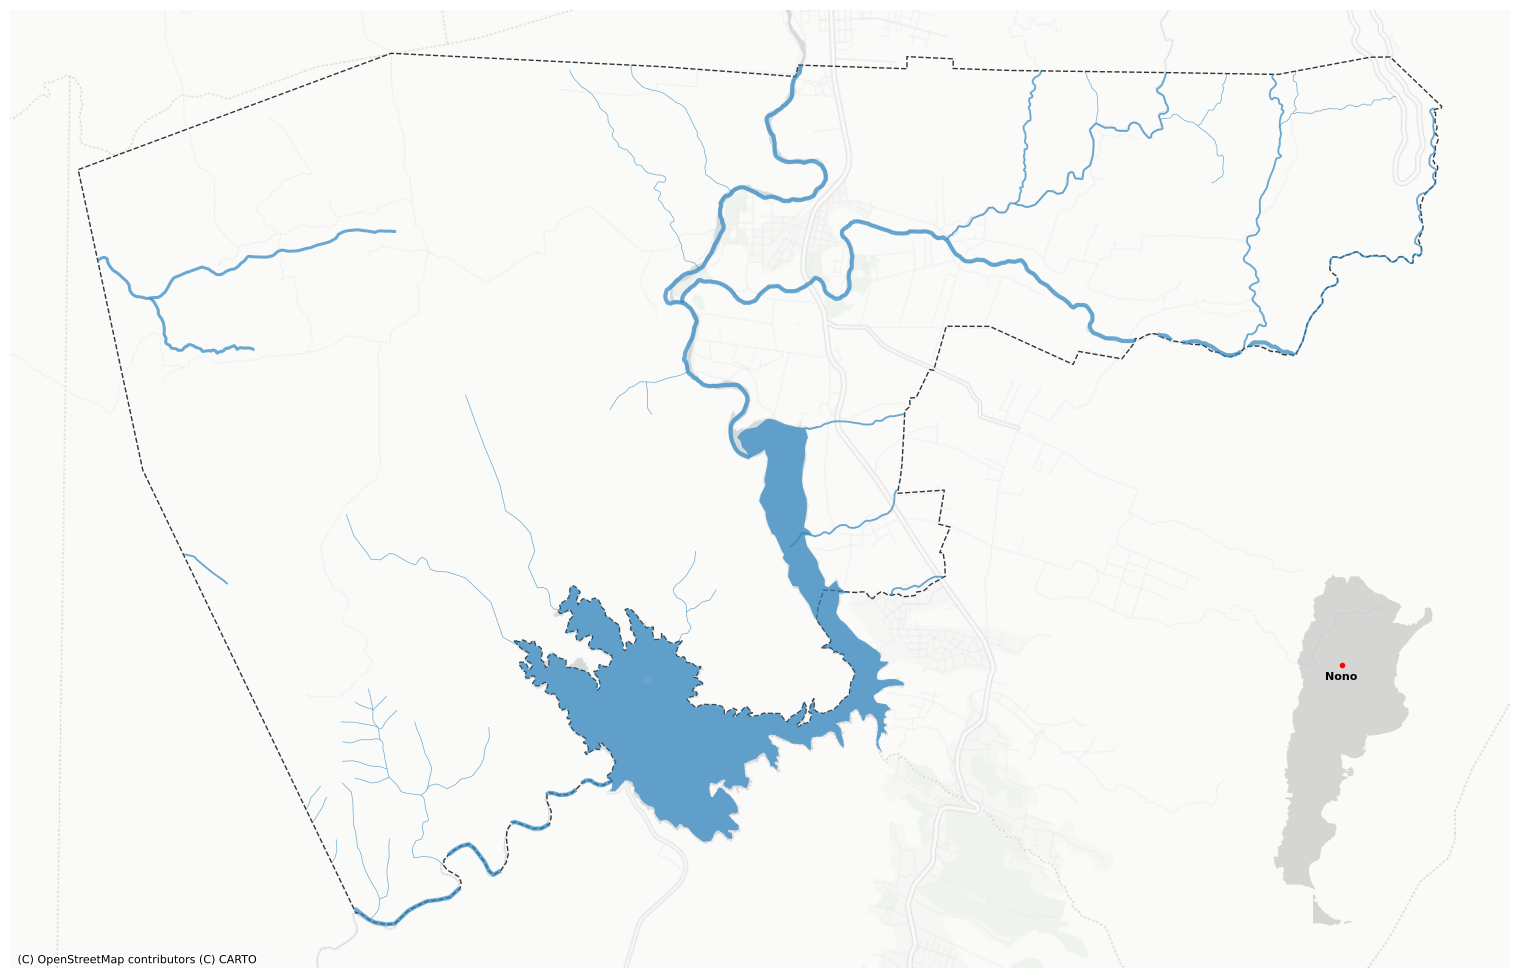

In [54]:
# Create the main figure and axis
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary with 5% padding
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Add basemap to main map
ctx.add_basemap(
    ax,
    crs=nono_3857.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0,
    zoom=13,
)



# Plot vector data with dark grey boundary
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#333333",  # Dark grey color
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(
    ax=ax,
    color=COLORS["water"],
    alpha=0.7,
    zorder=3
)

# Create inset map using inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="40%", height="40%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.02, 1, 1),
                   bbox_transform=ax.transAxes)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(nono_center.x, nono_center.y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for Nono
axins.text(nono_center.x, nono_center.y - 100000,
          'Nono', 
          fontsize=8, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from both maps
ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [58]:
# Load flood depth data
flood_depth_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"
flood_depth = load_raster_data(flood_depth_url)

# Reproject to Web Mercator and clip to Nono extent
flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

/tmp/ipykernel_21064/1733748717.py:83: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


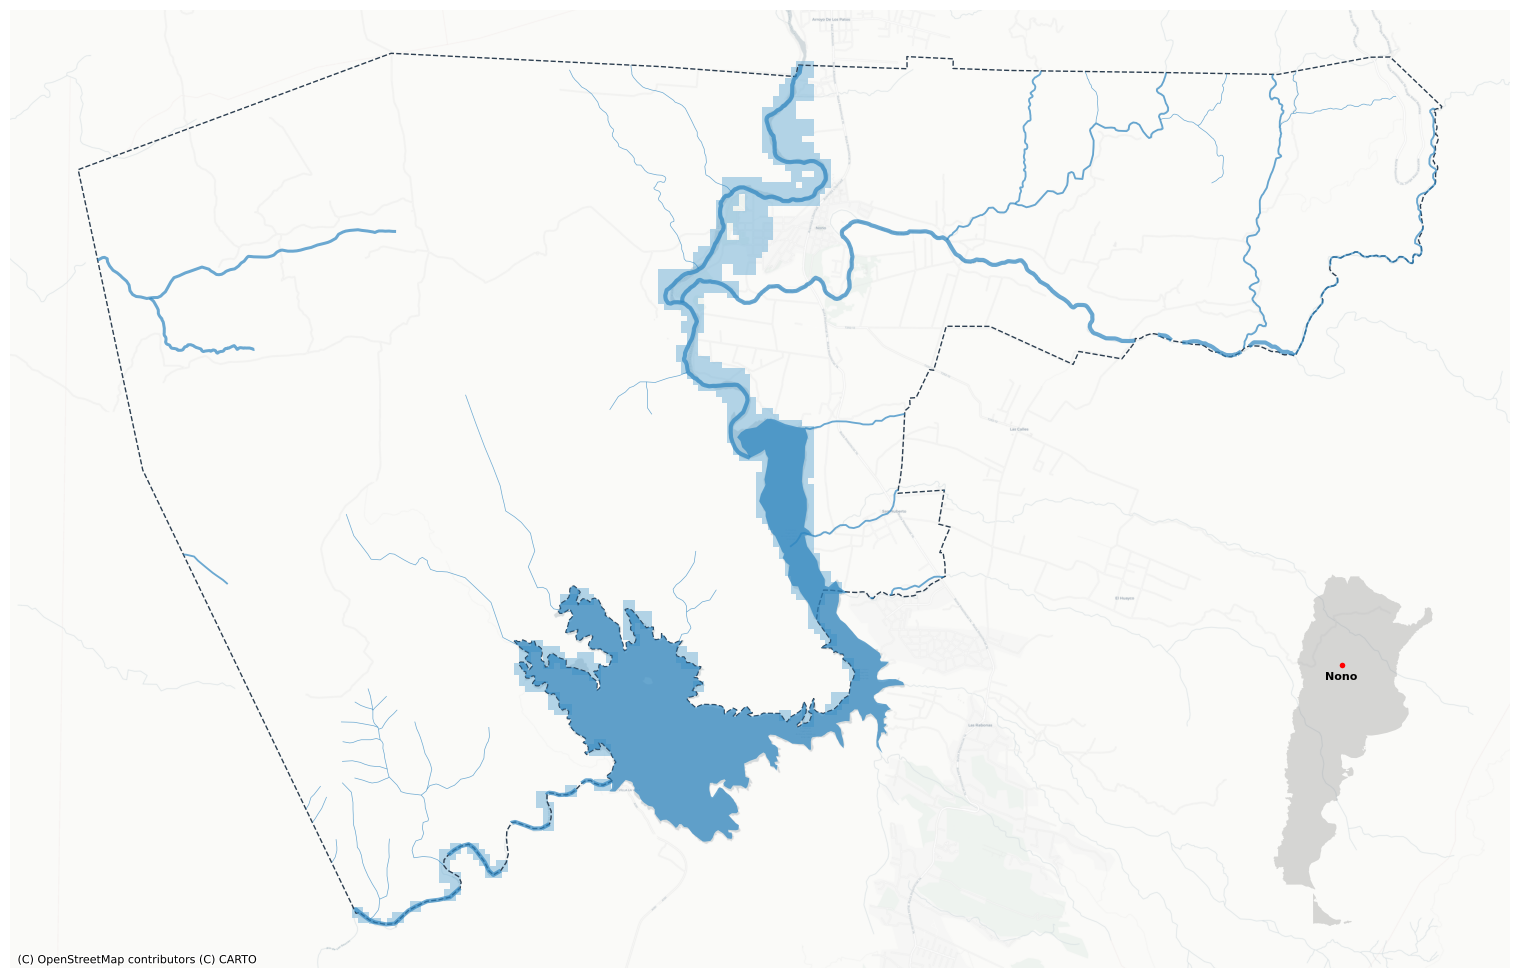

In [123]:
# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=flood_depth_3857.rio.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0,
    zoom=15,
)

# Plot the flood mask - only show where it's True
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax, alpha=0.5, cmap="Blues", zorder=1, add_colorbar=False
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(
    ax=ax,
    color=COLORS["water"],
    alpha=0.7,
    zorder=3
)

# Create inset map using inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="40%", height="40%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.02, 1, 1),
                   bbox_transform=ax.transAxes)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(nono_center.x, nono_center.y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for Nono
axins.text(nono_center.x, nono_center.y - 100000,
          'Nono', 
          fontsize=8, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from both maps
ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [65]:
# Load GHSL data
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

# Reproject and clip GHSL data in one step
ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry)


/tmp/ipykernel_21064/1126389798.py:80: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


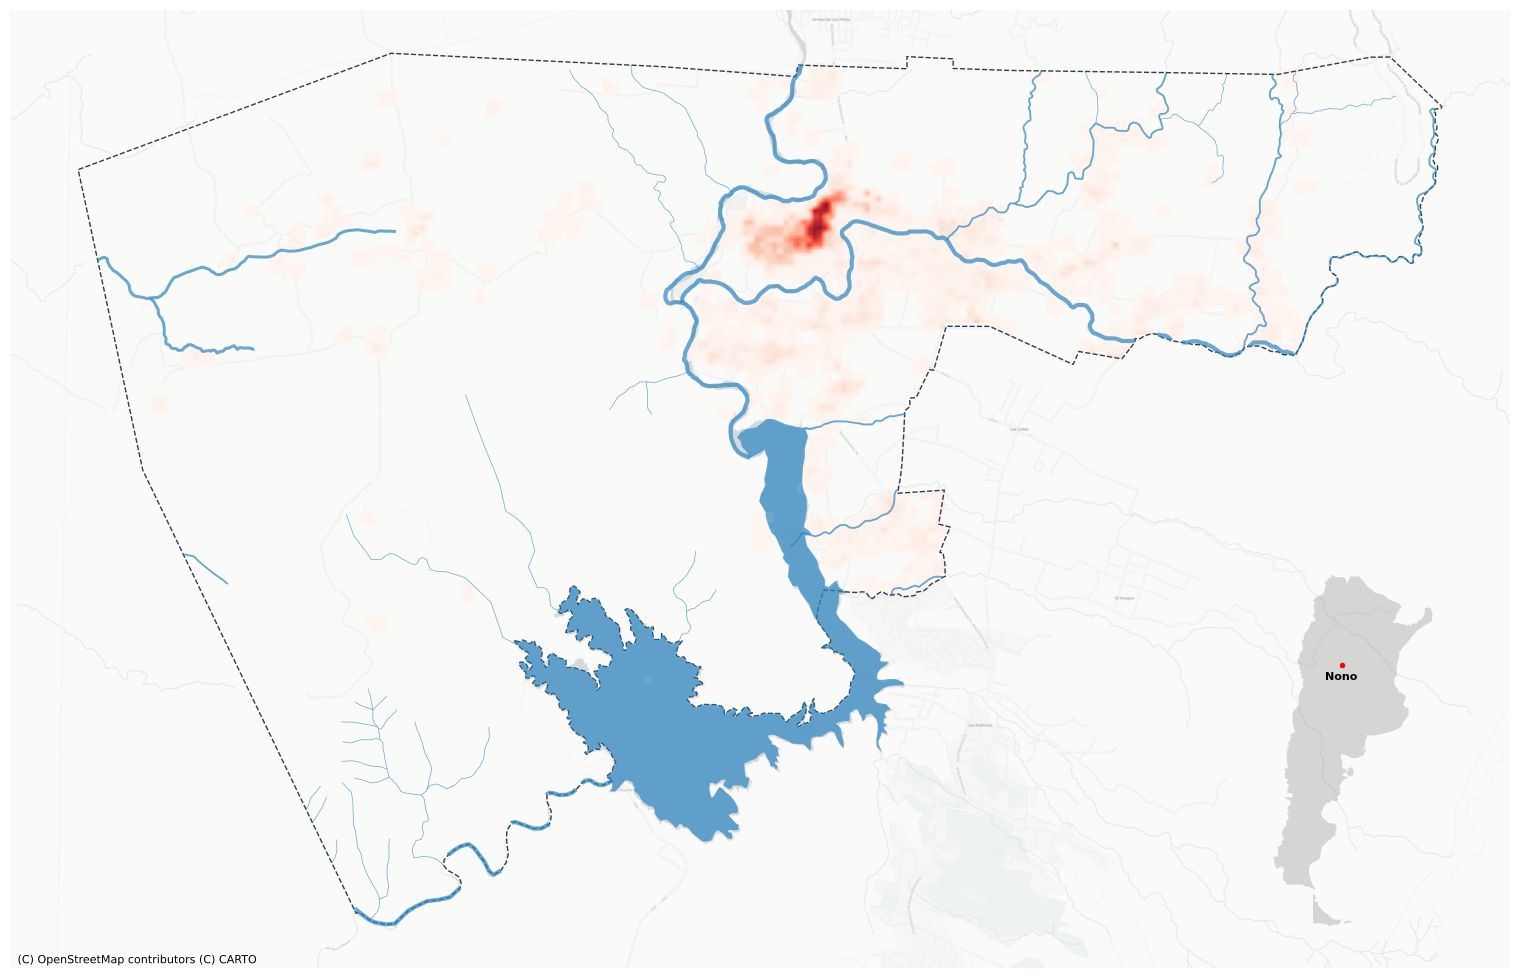

In [ ]:
# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Rasterize the GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=ghsl_3857.rio.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0,
    zoom=15,
)

# Plot the GHSL data with plasma colormap, excluding zeros
ghsl_agg.where(ghsl_agg > 0).plot.imshow(
    ax=ax, cmap="Reds", zorder=1, add_colorbar=False, alpha=0.9
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(
    ax=ax,
    color=COLORS["water"],
    alpha=0.7,
    zorder=3
)

# Create inset map using inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="40%", height="40%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.02, 1, 1),
                   bbox_transform=ax.transAxes)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(nono_center.x, nono_center.y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for Nono
axins.text(nono_center.x, nono_center.y - 100000,
          'Nono', 
          fontsize=8, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from both maps
ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

In [67]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())

    if parent_id in partitions:
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")  # or whatever region is appropriate
con.execute("SET s3_endpoint='data.source.coop'")  # Note: removed https://
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

/tmp/ipykernel_21064/2645526401.py:76: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


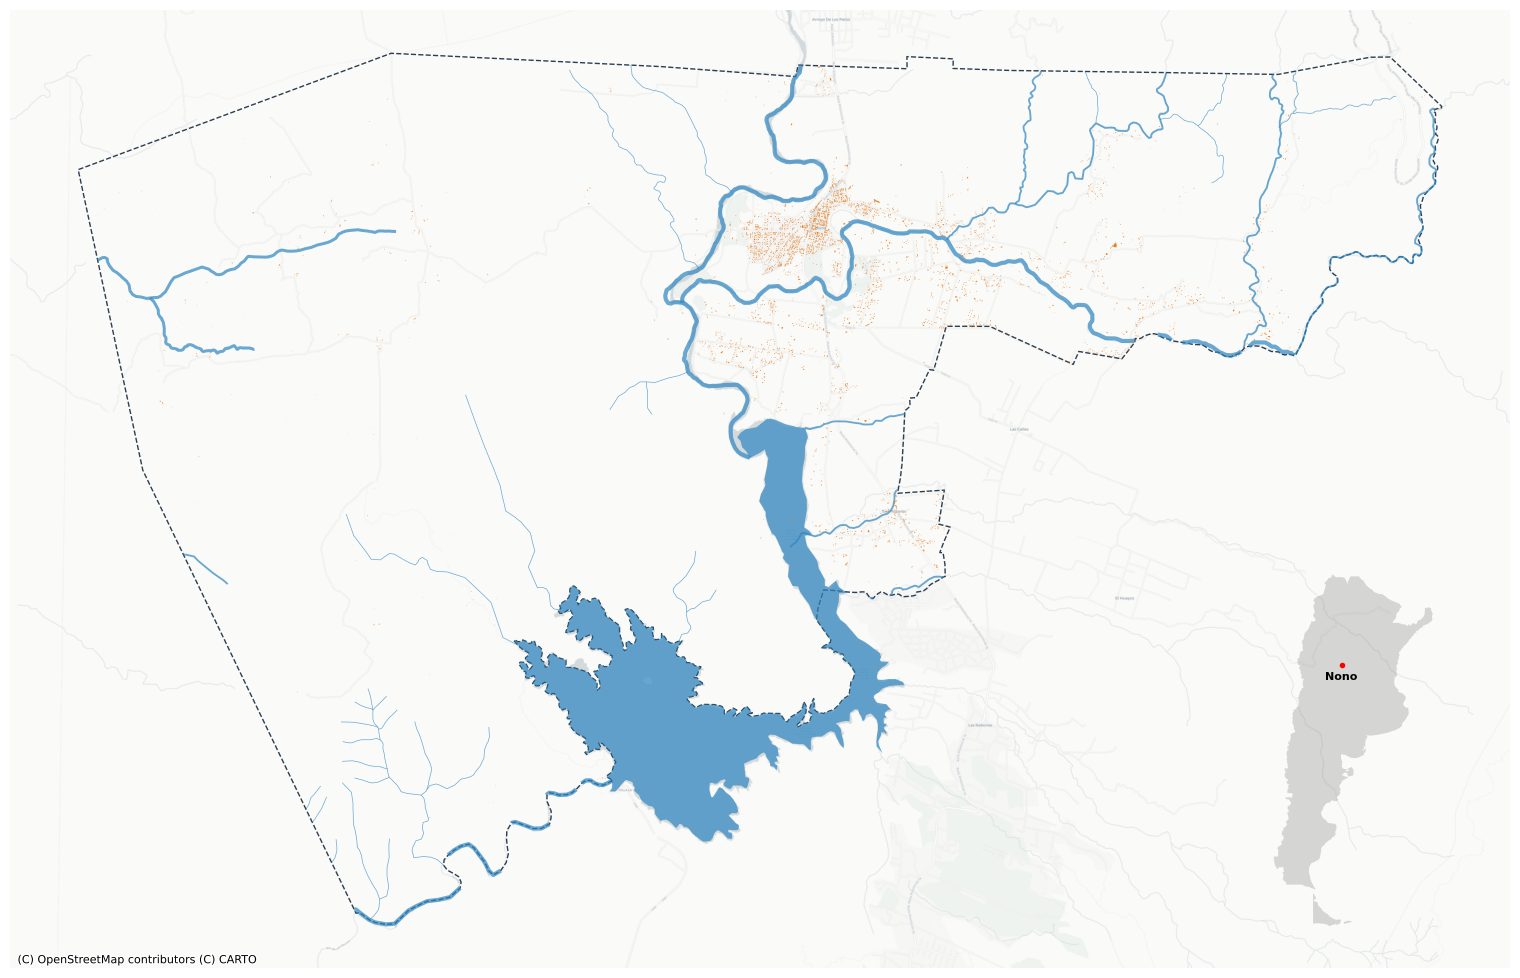

In [ ]:
# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=nono_3857.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0,
    zoom=15,
)

# Plot vector data
nono_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(
    ax=ax,
    color=COLORS["water"],
    alpha=0.7,
    zorder=3
)

# Plot buildings in dark orange/brown without edges
buildings_3857.plot(
    ax=ax,
    color=COLORS["buildings"],
    zorder=4,
)

# Create inset map using inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="40%", height="40%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.02, 1, 1),
                   bbox_transform=ax.transAxes)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(nono_center.x, nono_center.y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for Nono
axins.text(nono_center.x, nono_center.y - 100000,
          'Nono', 
          fontsize=8, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from both maps
ax.set_axis_off()
axins.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

/tmp/ipykernel_21064/3803864132.py:91: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  nono_center = nono_3857.geometry.unary_union.centroid


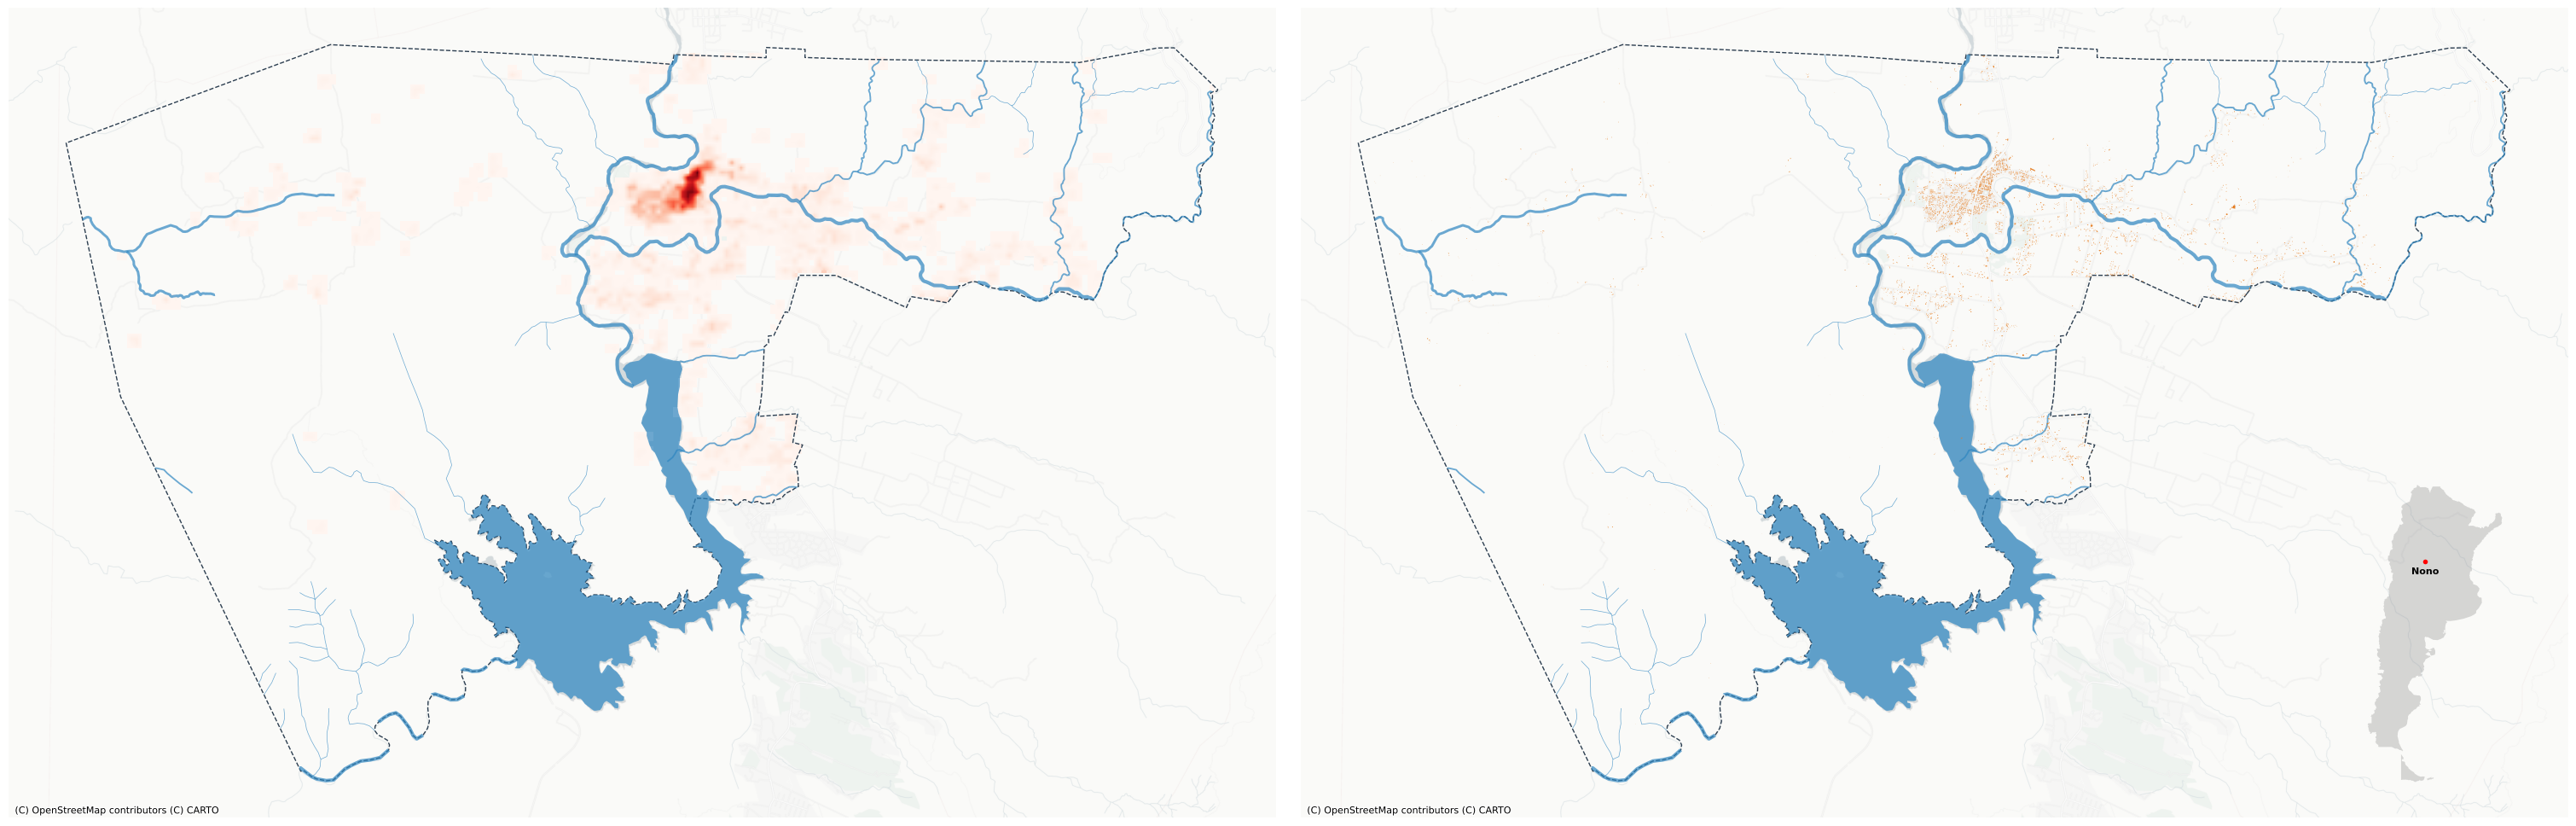

In [161]:
# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Set the plot limits to match the Nono boundary for both subplots
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05

for ax in [ax1, ax2]:
    ax.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
    ax.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Rasterize the GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Add basemap to both axes
for ax in [ax1, ax2]:
    ctx.add_basemap(
        ax,
        crs=ghsl_3857.rio.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=15,
    )

# Plot the GHSL data on first axis with plasma colormap, excluding zeros
ghsl_agg.where(ghsl_agg > 0).plot.imshow(
    ax=ax1, cmap="Reds", zorder=1, add_colorbar=False, alpha=1.0
)

# Plot vector data on both axes
for ax in [ax1, ax2]:
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor=COLORS["boundary"],
        linestyle="--",
        linewidth=1,
        zorder=2,
    )

    # Plot water courses
    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

    # Plot bodies of water
    cuerpos_de_agua_nono_3857.plot(
        ax=ax,
        color=COLORS["water"],
        alpha=0.7,
        zorder=3
    )

# Plot buildings on second axis
buildings_3857.plot(
    ax=ax2,
    color=COLORS["buildings"],
    zorder=4,
)

# Create inset map using inset_axes for the second plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax2, width="40%", height="40%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.02, 1, 1),
                   bbox_transform=ax2.transAxes)

# Plot Argentina outline in inset with white fill
argentina_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Argentina with some padding
inset_bounds = argentina_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for Nono's location
nono_center = nono_3857.geometry.unary_union.centroid
axins.plot(nono_center.x, nono_center.y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for Nono
axins.text(nono_center.x, nono_center.y - 100000,
          'Nono', 
          fontsize=8, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from all maps
for ax in [ax1, ax2, axins]:
    ax.set_axis_off()

# Add a clean border around the inset map
for spine in axins.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)

plt.show()

In [69]:

def union(x):
    return unary_union(x)


# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# Get coordinates and values
x, y = flood_depth_3857.x.values, flood_depth_3857.y.values
x, y = np.meshgrid(x, y)
x, y = x.flatten(), y.flatten()
values = flood_mask.sel(band=1).values.flatten()

# Convert to DataFrame and filter for flood areas
flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
flood_pd = flood_pd[flood_pd["flood"] == True]

# Create vector data
flood_vector = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_xy(
        flood_pd["x"], flood_pd["y"], crs=flood_depth_3857.rio.crs
    )
)
flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons

# Convert to list of geometries and chunk for parallel processing
geoms = list(flood_vector.geometry)
geom_arr = [geoms[i : i + 10000] for i in range(0, len(geoms), 10000)]

# Parallel union operation
with Pool(cpu_count()) as p:
    geom_union = p.map(union, geom_arr)

# Final union
flood_polygons = unary_union(geom_union)
flood_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries(flood_polygons), crs=flood_depth_3857.rio.crs
)

# Calculate population statistics
affine = ghsl_3857.rio.transform()
stats = zonal_stats(
    flood_gdf.geometry.tolist(),
    ghsl_3857.sel(band=1).values,
    stats=["sum"],
    nodata=-9999,
    affine=affine,
)
population_in_flood = sum(stat["sum"] for stat in stats if stat["sum"] is not None)
total_population = ghsl_3857.sel(band=1).sum().item()
population_percentage = (population_in_flood / total_population) * 100

# Calculate building statistics
buildings_in_flood = gpd.sjoin(
    buildings_3857, flood_gdf, how="inner", predicate="within"
)
total_buildings = len(buildings_3857)
buildings_exposed = len(buildings_in_flood)
buildings_percentage = (buildings_exposed / total_buildings) * 100


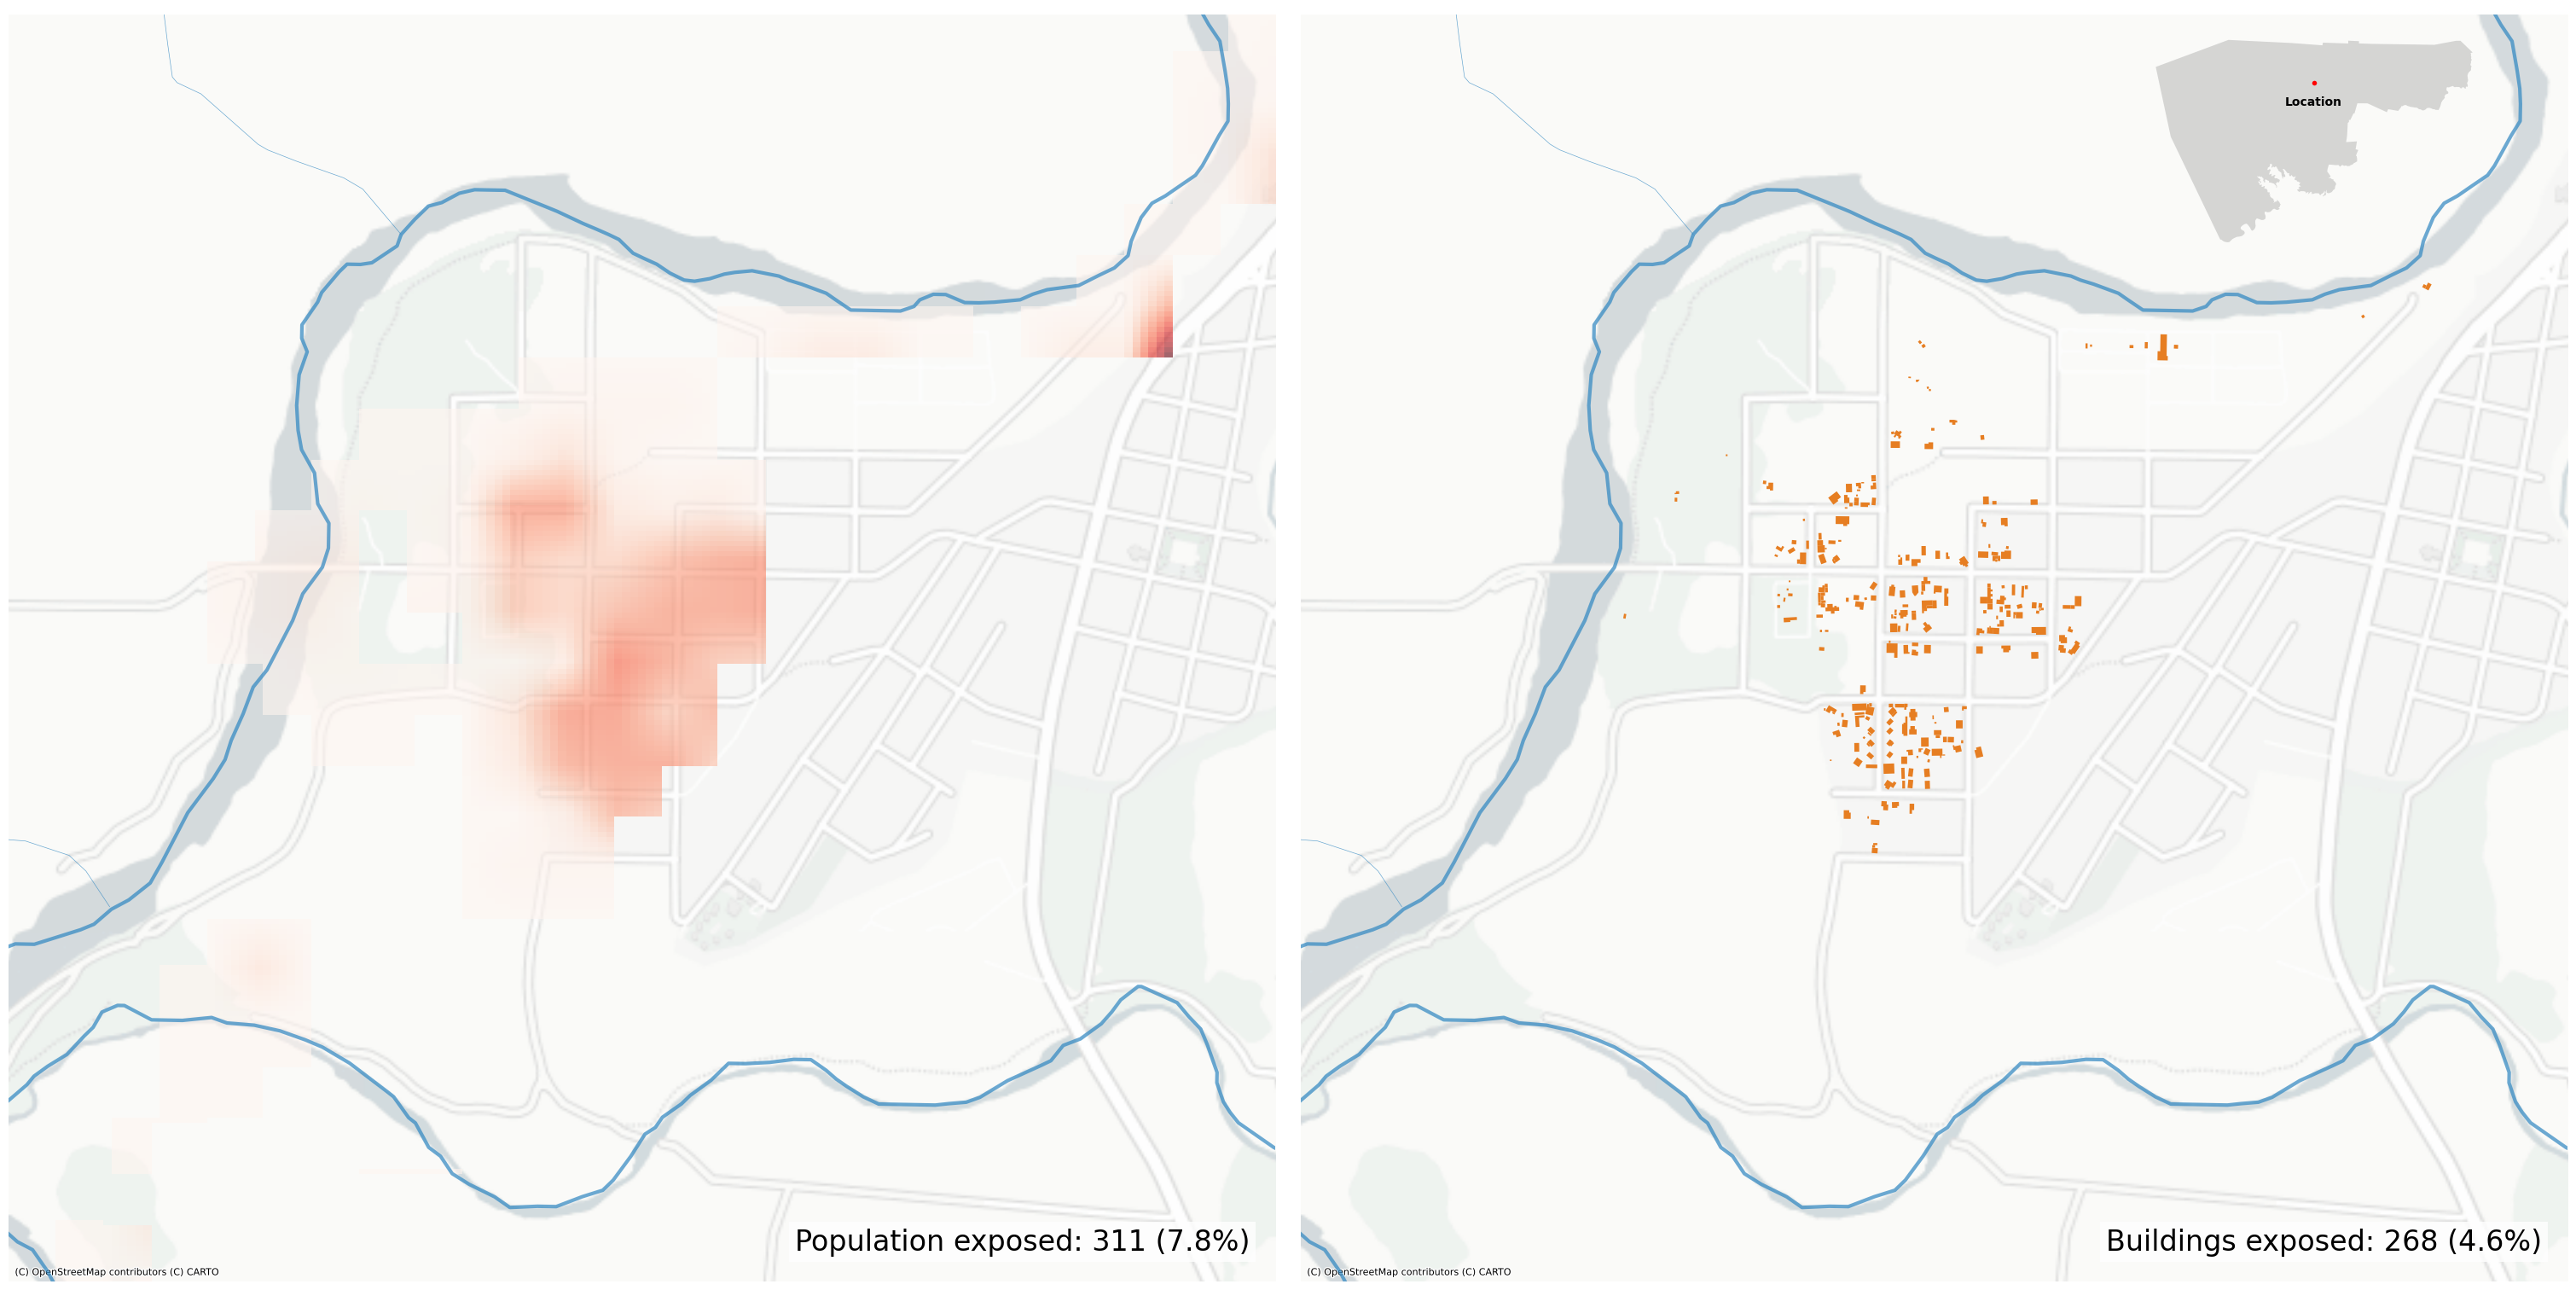

In [160]:
# Calculate weighted centroid
weighted_x = (buildings_in_flood.geometry.centroid.x * buildings_in_flood.geometry.area).sum() / buildings_in_flood.geometry.area.sum()
weighted_y = (buildings_in_flood.geometry.centroid.y * buildings_in_flood.geometry.area).sum() / buildings_in_flood.geometry.area.sum()

# Create a square around the centroid
size = 2500  # meters
square = gpd.GeoDataFrame(
    geometry=[box(weighted_x - size/2, weighted_y - size/2, 
                 weighted_x + size/2, weighted_y + size/2)],
    crs=buildings_in_flood.crs
)

# Get the bounds of our square
square_bounds = square.total_bounds

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Set the plot limits to match our square
for ax in [ax1, ax2]:
    ax.set_xlim(square_bounds[0], square_bounds[2])
    ax.set_ylim(square_bounds[1], square_bounds[3])

# Create inset axes for the second plot
axins = ax2.inset_axes([0.65, 0.75, 0.3, 0.3])  # Changed from [0.02, 0.02, 0.3, 0.3]

# Plot Nono boundary in inset
nono_3857.plot(
    ax=axins,
    facecolor='grey',
    edgecolor='none',
    linewidth=0.8,
    alpha=0.3,
    zorder=1
)

# Set inset limits to show Nono with some padding
inset_bounds = nono_3857.total_bounds
inset_padding = (inset_bounds[2] - inset_bounds[0]) * 0.1
axins.set_xlim(inset_bounds[0] - inset_padding, inset_bounds[2] + inset_padding)
axins.set_ylim(inset_bounds[1] - inset_padding, inset_bounds[3] + inset_padding)

# Add point marker for weighted centroid location
axins.plot(weighted_x, weighted_y, 
          marker='o', 
          color='red', 
          markersize=4, 
          markeredgecolor='none',
          markeredgewidth=1,
          zorder=3)

# Add text label for the centroid
axins.text(weighted_x, weighted_y - 1000,
          'Location', 
          fontsize=10, 
          ha='center', 
          va='top',
          color='black',
          fontweight='bold',
          bbox=dict(boxstyle='round,pad=0.2', facecolor='none', alpha=0.8, edgecolor='none'),
          zorder=4)

# Remove axis labels and ticks from inset
axins.set_axis_off()

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# First rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Then rasterize GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Apply the mask to the rasterized data and remove zero population areas
masked_ghsl = ghsl_agg.where(flood_agg)
masked_ghsl = masked_ghsl.where(masked_ghsl > 0)  # Only show areas with population

# Add basemap to both axes
for ax in [ax1, ax2]:
    ctx.add_basemap(
        ax,
        crs=flood_depth_3857.rio.crs,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=15,
    )

# Plot the masked population data on first axis
masked_ghsl.plot.imshow(ax=ax1, alpha=0.6, cmap="Reds", zorder=1, add_colorbar=False)

# Plot vector data on both axes
for ax in [ax1, ax2]:
    nono_3857.plot(
        ax=ax,
        facecolor="none",
        edgecolor=COLORS["boundary"],
        linestyle="--",
        linewidth=1,
        zorder=2,
    )

    # Plot water courses
    for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
        subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
        line_width = scale_line_width(orden)
        subset.plot(
            ax=ax, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3
        )

        # Plot bodies of water
        cuerpos_de_agua_nono_3857.plot(
            ax=ax,
            color=COLORS["water"],
            alpha=0.7,
            zorder=3
        )

# Plot only exposed buildings on second axis
buildings_in_flood.plot(
    ax=ax2,
    color=COLORS["buildings"],
    zorder=4,
)

# Add exposure statistics to each subfigure
# Population exposure stats for first subfigure
ax1.text(
    0.98, 0.02,
    f"Population exposed: {population_in_flood:,.0f} ({population_percentage:.1f}%)",
    transform=ax1.transAxes,
    ha='right',
    va='bottom',
    fontsize=24,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=5),
    zorder=5
)

# Building exposure stats for second subfigure
ax2.text(
    0.98, 0.02,
    f"Buildings exposed: {buildings_exposed:,} ({buildings_percentage:.1f}%)",
    transform=ax2.transAxes,
    ha='right',
    va='bottom',
    fontsize=24,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=5),
    zorder=5
)

# Remove axis labels and ticks
for ax in [ax1, ax2]:
    ax.set_axis_off()

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02)

plt.show()

In [72]:
import logging
import time
from datetime import timedelta
import xarray as xr

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

def load_all_return_periods(base_url, return_periods):
    """
    Load multiple return period flood depth rasters into a single xarray dataset.
    
    Parameters:
    -----------
    base_url : str
        Base URL for the flood depth data
    return_periods : list
        List of return periods to load (e.g., [10, 20, 50, 75, 100, 200, 500])
    
    Returns:
    --------
    xarray.Dataset
        Dataset containing all return period flood depths
    """
    start_time = time.time()
    logging.info(f"Starting to load {len(return_periods)} return periods")
    
    # Create empty list to store datasets
    datasets = []
    
    # Load each return period
    for i, rp in enumerate(return_periods, 1):
        rp_start = time.time()
        logging.info(f"Loading return period {rp} ({i}/{len(return_periods)})")
        
        # Construct URL for this return period
        url = base_url.replace('RP100', f'RP{rp}')
        logging.info(f"  URL: {url}")
        
        # Load and reproject data
        flood_depth = rio.open_rasterio(url, masked=True)
        
        flood_depth_3857 = flood_depth.rio.reproject(
            dst_crs="EPSG:3857",
            resolution=100,  # 100m resolution
        )
        
        flood_depth_3857 = flood_depth_3857.rio.clip(nono_3857.geometry, from_disk=True)
        
        # Add return period as a dimension
        flood_depth_3857 = flood_depth_3857.expand_dims({'return_period': [rp]})
        
        datasets.append(flood_depth_3857)
    
    
    logging.info("Combining all datasets...")
    combined = xr.concat(datasets, dim='return_period')
    
    total_time = time.time() - start_time
    logging.info(f"Finished loading all return periods in {timedelta(seconds=int(total_time))}")
    
    return combined

# Define return periods and base URL
return_periods = [10, 20, 50, 75, 100, 200, 500]
base_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"

# Load all return periods
flood_depths = load_all_return_periods(base_url, return_periods)

2025-05-23 11:01:37,794 - INFO - Starting to load 7 return periods
2025-05-23 11:01:37,795 - INFO - Loading return period 10 (1/7)
2025-05-23 11:01:37,795 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP10/ID74_S30_W70_RP10_depth.tif
2025-05-23 11:01:58,383 - INFO - Loading return period 20 (2/7)
2025-05-23 11:01:58,383 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP20/ID74_S30_W70_RP20_depth.tif
2025-05-23 11:02:18,557 - INFO - Loading return period 50 (3/7)
2025-05-23 11:02:18,557 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP50/ID74_S30_W70_RP50_depth.tif
2025-05-23 11:02:35,433 - INFO - Loading return period 75 (4/7)
2025-05-23 11:02:35,434 - INFO -   URL: https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP75/ID74_S30_W70_RP75_depth.tif
2025-05-23 11:02:59,239 - INFO - Loading return period 100 (5/7)
2025-05-23 11:02:59,239 

In [94]:
# Calculate exposure for each return period
exposure_results = []

for rp in flood_depths.return_period.values:
    # Create mask for this return period
    flood_mask = flood_depths.sel(return_period=rp) > 0
    
    # Create flood polygons for this return period
    x, y = flood_depths.x.values, flood_depths.y.values
    x, y = np.meshgrid(x, y)
    x, y = x.flatten(), y.flatten()
    values = flood_mask.sel(band=1).values.flatten()
    
    # Convert to DataFrame and filter for flood areas
    # Convert to DataFrame and filter for flood areas
    flood_pd = pd.DataFrame.from_dict({"flood": values, "x": x, "y": y})
    flood_pd = flood_pd[
        flood_pd["flood"].astype(bool)
    ]  # Convert to boolean before filtering
    
    # Create vector data
    flood_vector = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_xy(flood_pd['x'], flood_pd['y'], crs=flood_depths.rio.crs)
    )
    flood_vector = flood_vector.buffer(50, cap_style=3)  # Buffer to create polygons
    
    # Convert to list of geometries and chunk for parallel processing
    geoms = list(flood_vector.geometry)
    geom_arr = [geoms[i:i+10000] for i in range(0, len(geoms), 10000)]
    
    # Parallel union operation
    with Pool(cpu_count()) as p:
        geom_union = p.map(union, geom_arr)
    
    # Final union
    flood_polygons = unary_union(geom_union)
    flood_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(flood_polygons), crs=flood_depths.rio.crs)
    
    # Calculate population statistics using intersection
    stats = zonal_stats(
        flood_gdf.geometry.tolist(),
        ghsl_3857.sel(band=1).values,
        stats=['sum', 'count'],
        nodata=-9999,
        affine=affine,
        all_touched=True  # Include cells that touch the boundary
    )
    
    
    population_in_flood = sum(stat['sum'] for stat in stats if stat['sum'] is not None)
    total_population = ghsl_3857.sel(band=1).sum().item()
    population_percentage = (population_in_flood / total_population) * 100
    
    # Calculate building statistics using intersection
    buildings_in_flood = gpd.sjoin(buildings_3857, flood_gdf, how='inner', predicate='intersects')
    total_buildings = len(buildings_3857)
    buildings_exposed = len(buildings_in_flood)
    buildings_percentage = (buildings_exposed / total_buildings) * 100
    
    
    exposure_results.append({
        'return_period': rp,
        'population_exposed': population_in_flood,
        'population_percentage': population_percentage,
        'buildings_exposed': buildings_exposed,
        'buildings_percentage': buildings_percentage
    })

# Convert to DataFrame for easy analysis
exposure_df = pd.DataFrame(exposure_results)

In [98]:
# Convert return periods to annual probabilities
exposure_df['annual_probability'] = 1 / exposure_df['return_period']

# Sort by probability (ascending)
exposure_df = exposure_df.sort_values('annual_probability')

# Define the GEV function
def gev_function(x, loc, scale, shape):
    return genextreme.ppf(1 - x, shape, loc=loc, scale=scale)

/tmp/ipykernel_21064/449993968.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma") # Ensure this matches the cmap used for flood_agg


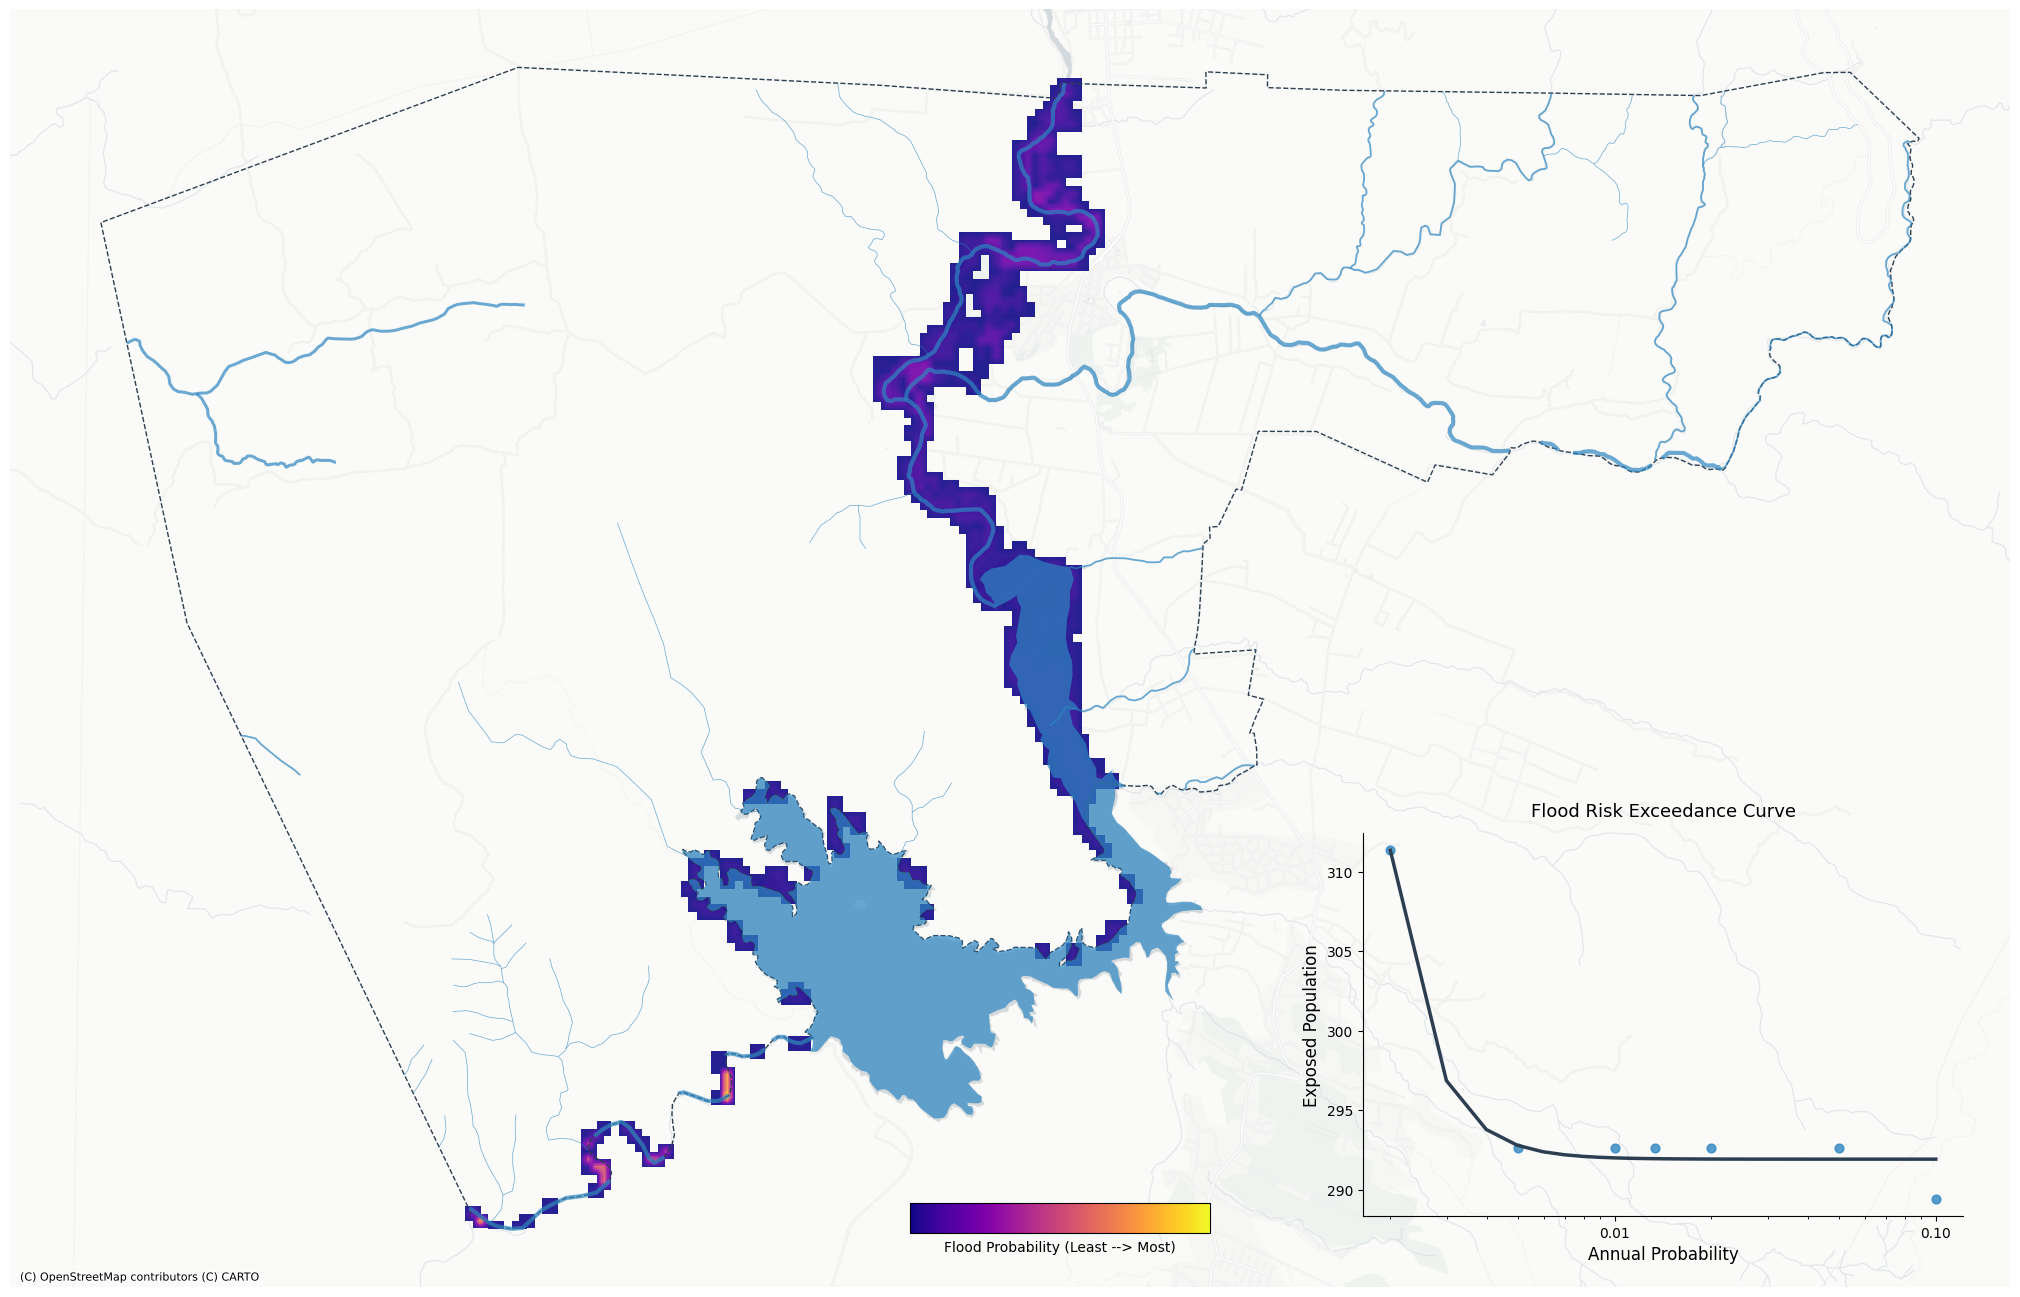

In [146]:
# Create a single subplot for the main map
fig, ax1 = plt.subplots(1, 1, figsize=(20, 15))

# Set the plot limits to match the Nono boundary for the map
bounds = nono_3857.total_bounds
width = bounds[2] - bounds[0]
height = bounds[3] - bounds[1]
padding_x = width * 0.05
padding_y = height * 0.05
ax1.set_xlim(bounds[0] - padding_x, bounds[2] + padding_x)
ax1.set_ylim(bounds[1] - padding_y, bounds[3] + padding_y)

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Sum flood depths across return periods
flood_sum = flood_depths.sum(dim='return_period')

# Rasterize the summed flood data
flood_agg = canvas.raster(flood_sum.sel(band=1))

# Add basemap
ctx.add_basemap(
    ax1,
    crs=flood_depths.rio.crs,
    source=ctx.providers.CartoDB.PositronNoLabels,
    zorder=0,
    zoom=15,
)

# Plot the summed flood data
flood_agg.where(flood_agg > 0).plot.imshow(
    ax=ax1, cmap="plasma", zorder=1, add_colorbar=False, alpha=0.9
)

# Plot vector data
nono_3857.plot(
    ax=ax1,
    facecolor="none",
    edgecolor=COLORS["boundary"],
    linestyle="--",
    linewidth=1,
    zorder=2,
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax1, color=COLORS["water"], linewidth=line_width, alpha=0.7, zorder=3)

# Plot bodies of water
cuerpos_de_agua_nono_3857.plot(
    ax=ax1,
    color=COLORS["water"],
    alpha=0.7,
    zorder=3
)

# Create inset for exceedance curve using inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax1, width="30%", height="30%", loc='lower right',
                   bbox_to_anchor=(-0.02, 0.05, 1, 1),
                   bbox_transform=ax1.transAxes)

# Plot the exceedance curve in the inset
# Plot the actual data points
axins.scatter(
    exposure_df['annual_probability'], 
    exposure_df['population_exposed'], 
    color='#2E86C1',
    s=40,
    alpha=0.8
)

# Plot the fitted curve
axins.plot(x_fit, y_fit, color='#2C3E50', linewidth=2.5)

# Set labels and title for inset
axins.set_xlabel('Annual Probability', fontsize=12)
axins.set_ylabel('Exposed Population', fontsize=12)
axins.set_title('Flood Risk Exceedance Curve', fontsize=13, pad=12)

# Use log scale for x-axis
axins.set_xscale('log')
axins.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

# Clean minimal styling for inset
axins.grid(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False) 
axins.spines['left'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.tick_params(axis='both', which='major', labelsize=10)

# Add expected annual impact text to inset
# axins.text(
#     0.15, 
#     0.95, 
#     f'Expected Annual Impact: {expected_annual_impact:,.0f}',
#     transform=axins.transAxes,
#     bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', pad=3),
#     verticalalignment='top',
#     fontsize=11
# )

# Set white background with transparency for the entire inset area including labels
axins.patch.set_facecolor('none')
axins.patch.set_zorder(0)

# Remove axis labels and ticks from main map
ax1.set_axis_off()

import matplotlib.colors as mcolors
import matplotlib.cm as cm

# ... (your existing code) ...

# Get the maximum flood depth value for the colorbar normalization
max_flood_depth = flood_agg.max().item()

# Create a colormap and normalization object for the colorbar
cmap = cm.get_cmap("plasma") # Ensure this matches the cmap used for flood_agg
norm = mcolors.Normalize(vmin=0, vmax=max_flood_depth)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) # Required for ScalarMappable to work with colorbar without plotting data directly

# Create a new axes for the colorbar at the bottom of the figure
# [left, bottom, width, height] in normalized figure coordinates (0 to 1)
# Adjust these values to fine-tune position and size.
cbar_ax = fig.add_axes([0.45, 0.11, 0.15, 0.02]) # x_start, y_start, width, height

# Create the colorbar using the ScalarMappable and the dedicated axes
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

# Remove numeric labels and ticks from the colorbar
cbar.set_ticks([])
cbar.set_ticklabels([])

# Set the label for the colorbar, adjusting labelpad as ticks are removed
cbar.set_label("Flood Probability (Least --> Most)", fontsize=10, ha='center', labelpad=5)

# ... (rest of your existing code, including plt.show()) ...

# Remove all padding
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()